# Using Albumentations with Tensorflow

**Author**: [Ayushman Buragohain](https://github.com/benihime91)

In [26]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.4.0 is successfully installed


#### [Recommended] Update the version of tensorflow_datasets if you want to use it

- We'll we using an example from `tensorflow_datasets`.

In [27]:
! pip install --upgrade tensorflow_datasets tensorflow

## Run the example

In [28]:
# necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
import albumentations as A

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [29]:
tfds.__version__

'4.9.4'

In [30]:
# load in the tf_flowers dataset
data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [31]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/Users/vladimiriglovikov/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

## An Example Pipeline Using `tf.image`

## Process Data

In [32]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

ds_tf = data.map(partial(process_image, img_size=120), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_tf

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## View images from the dataset

In [33]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

2024-02-18 14:57:07.678378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


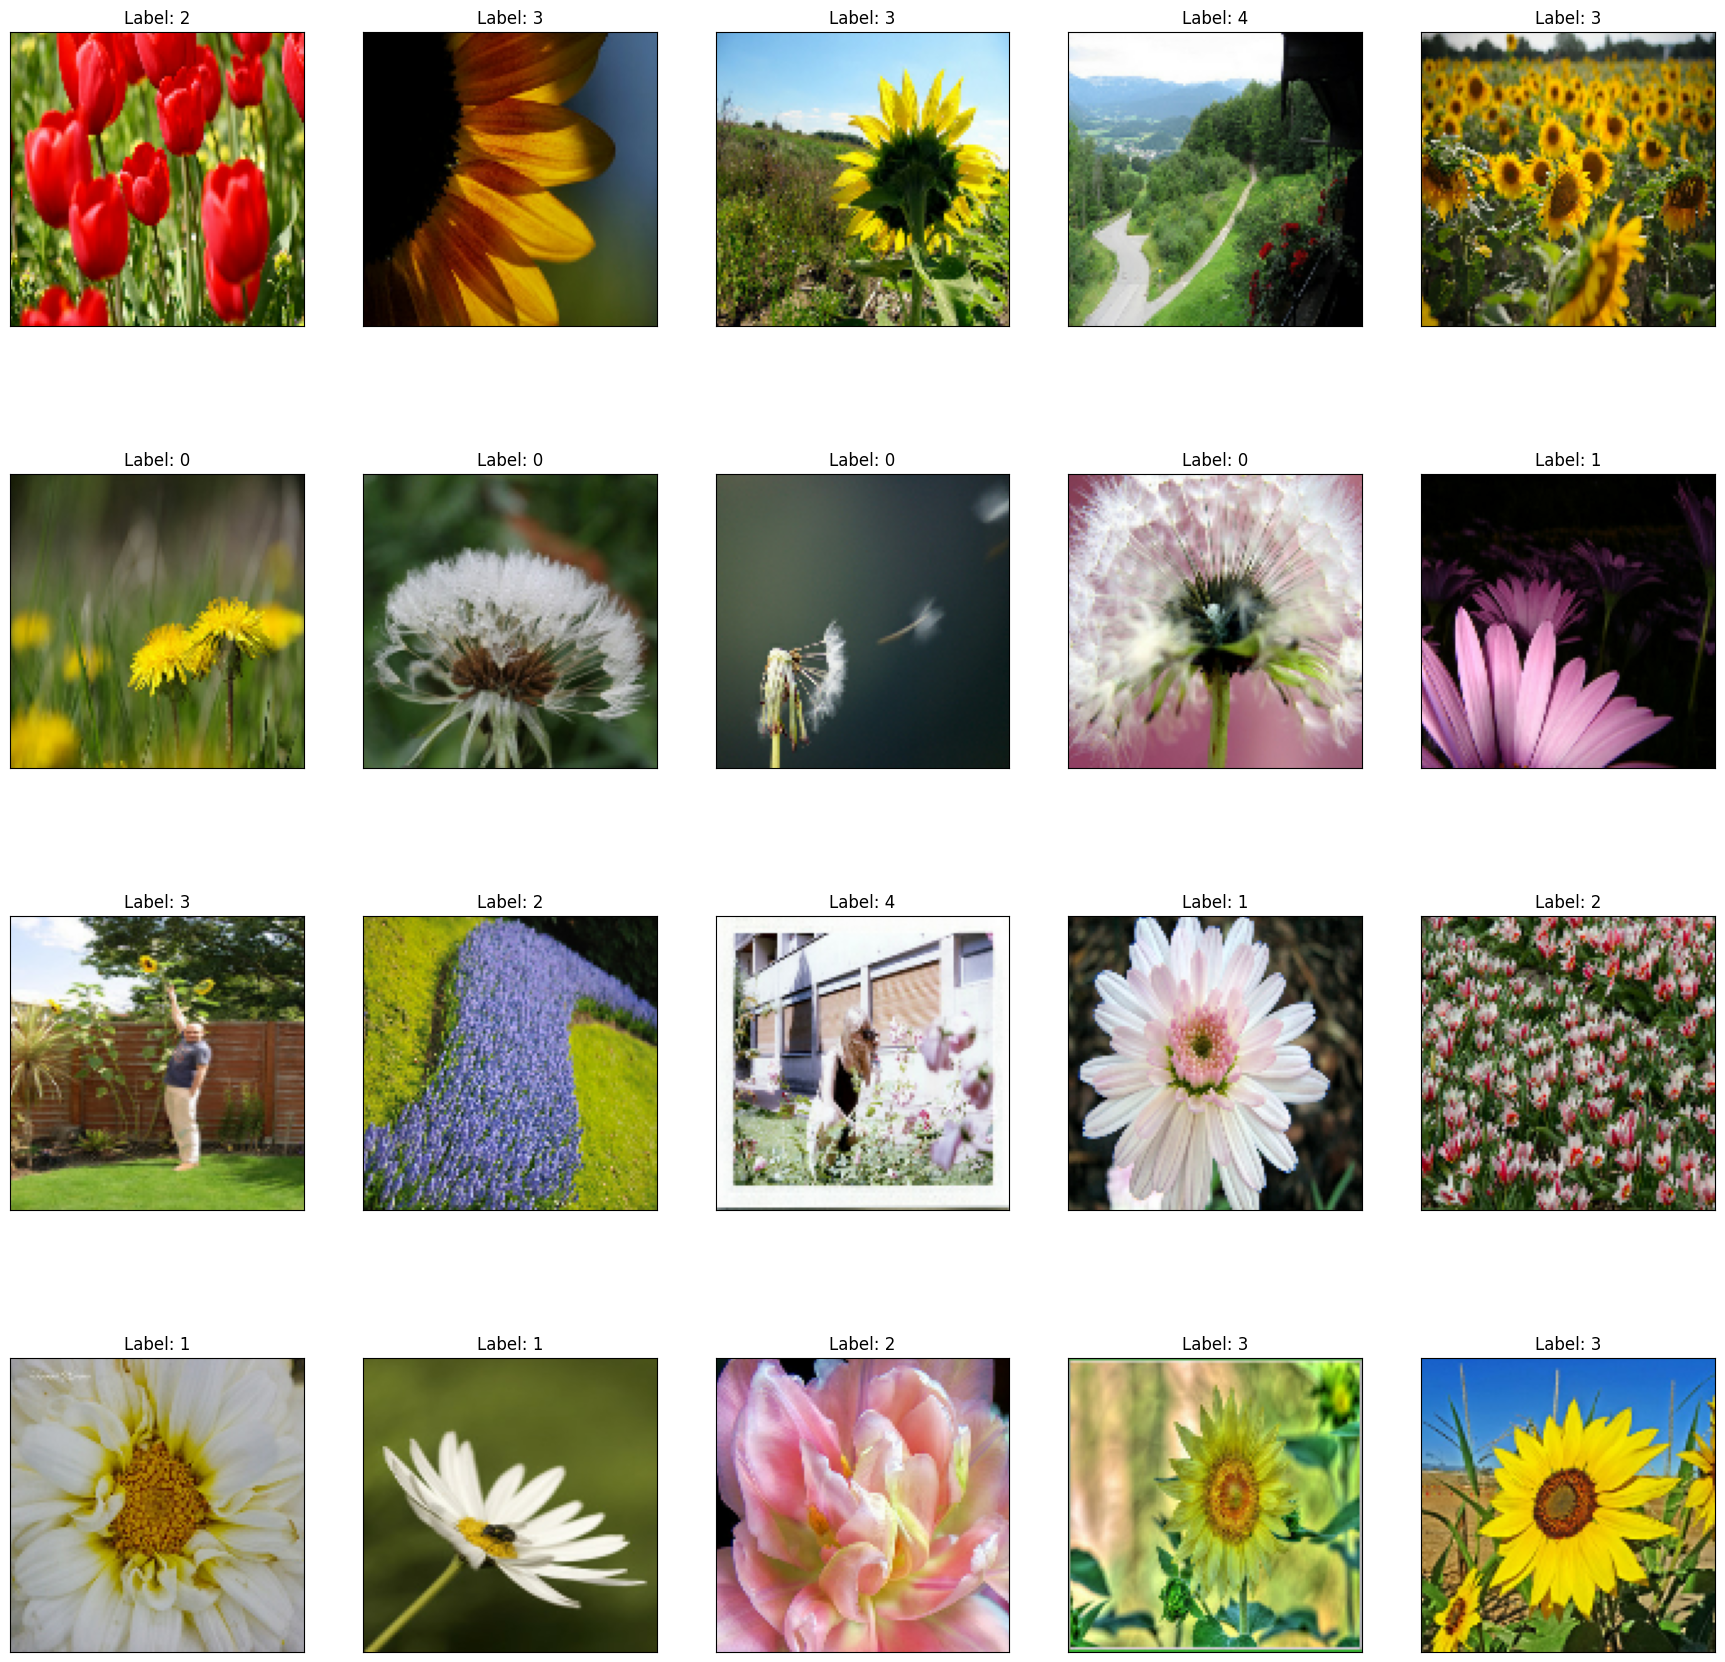

In [34]:
view_image(ds_tf)

Using `tf.image` is very efficient to create a pipeline but the disadvantage is that with `tf.image` we can only apply limited amounts of augmentations to our `input data`.
One way to solve is issue is to use `tf.keras` `ImageDataGenerator` class but `albumentations` is faster.

# An Example Pipeline using `albumentations`

To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

italicized text## Create Pipeline to Process data

In [35]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = A.Compose([
            A.Rotate(limit=40),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.HorizontalFlip(),
        ])

In [36]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [37]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [38]:
# create dataset
ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [39]:
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [40]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## View images from the dataset

2024-02-18 14:57:09.800432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


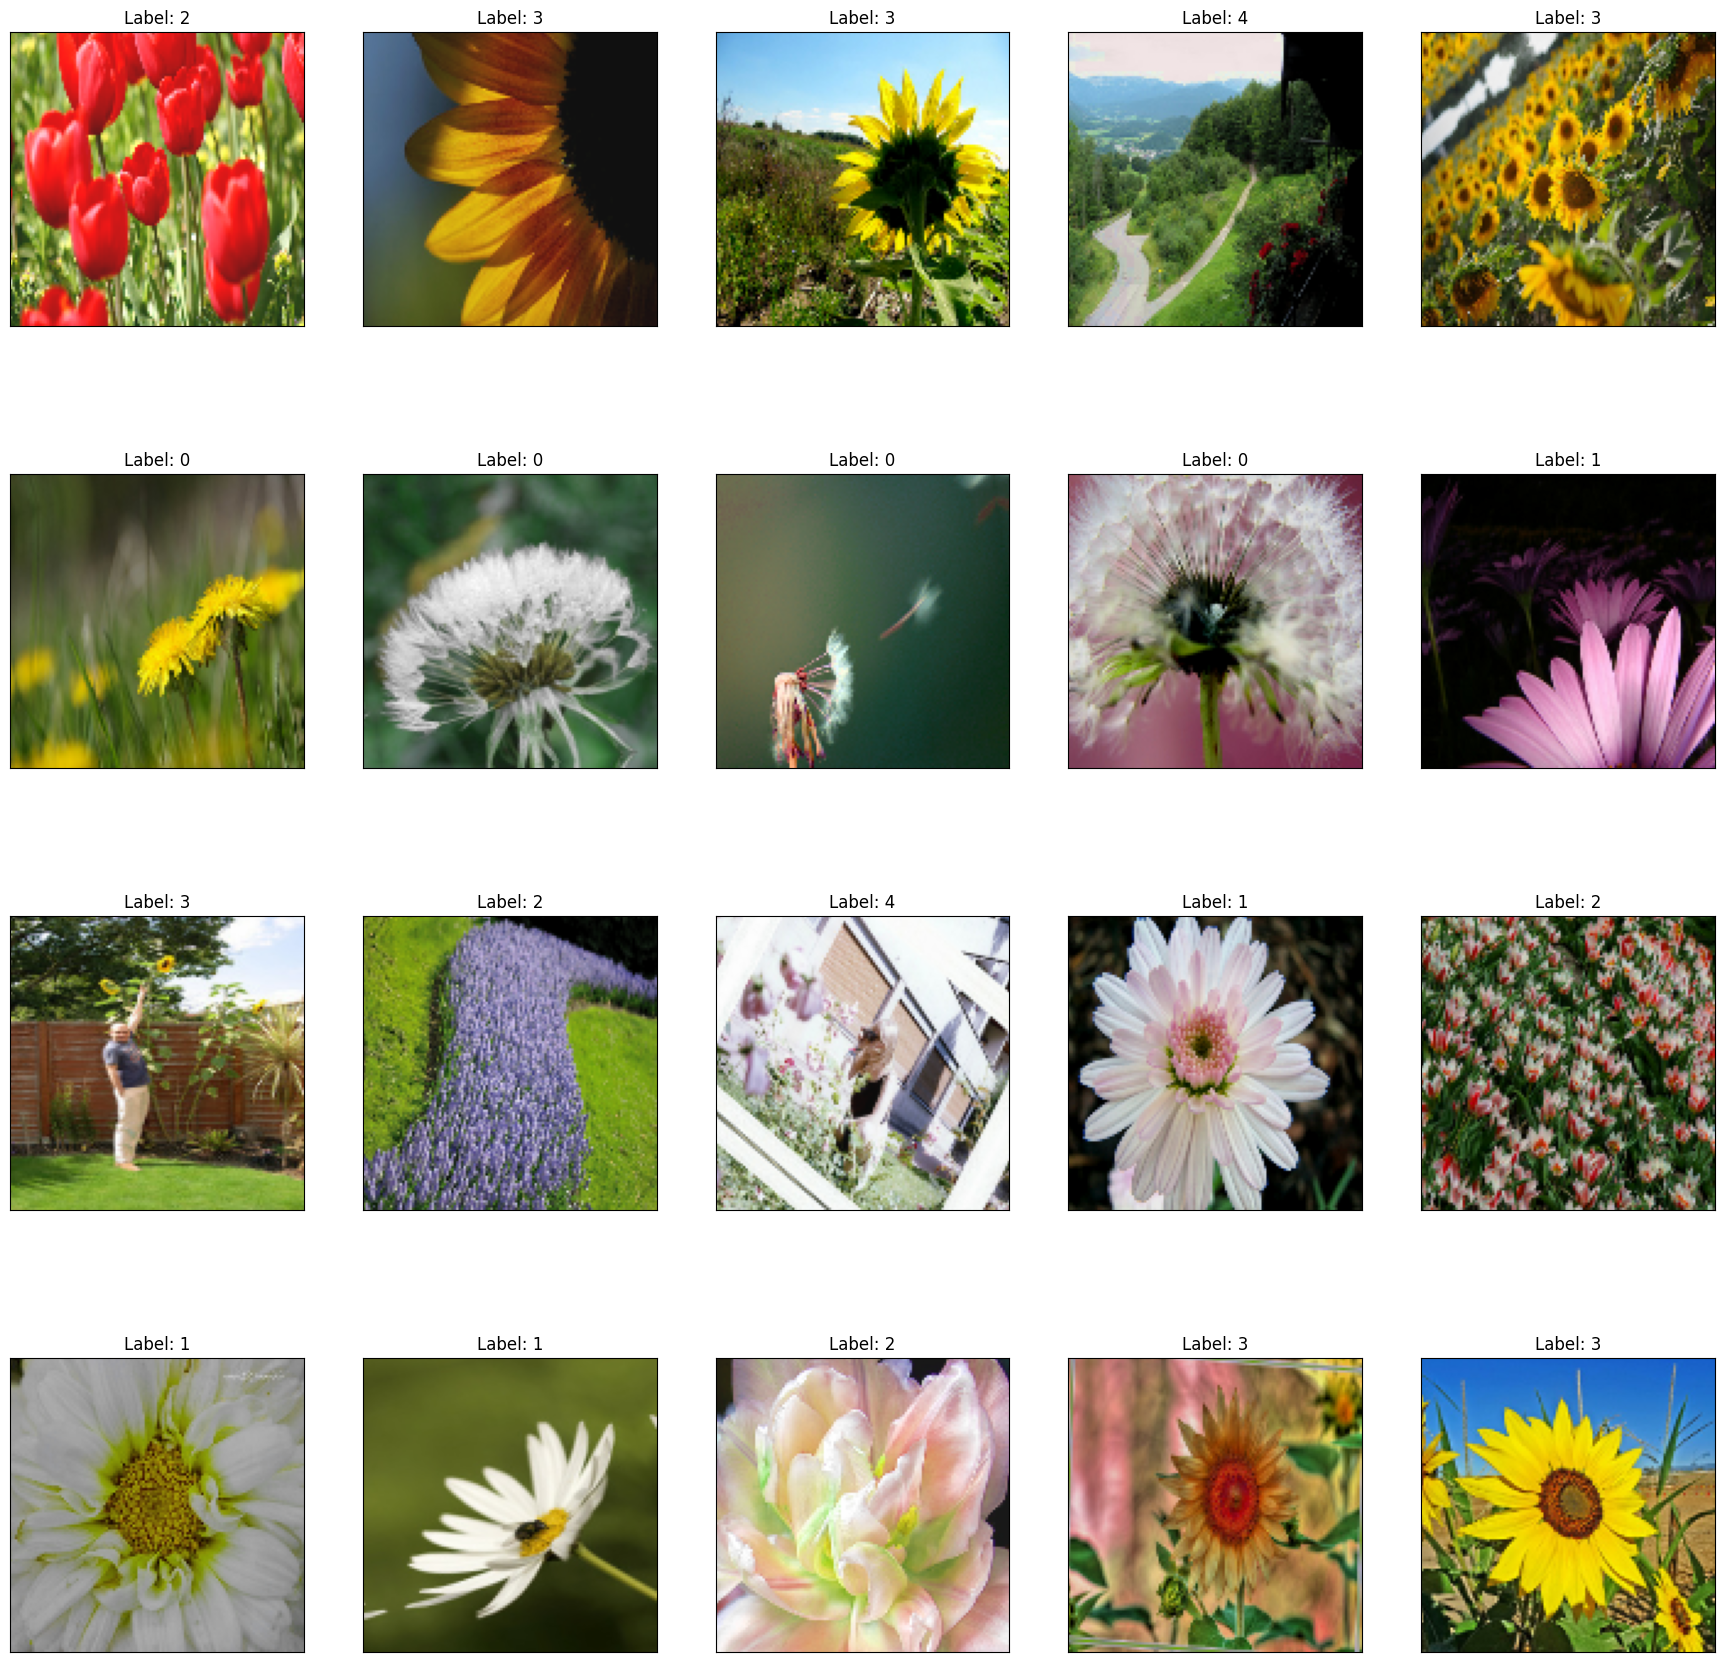

In [41]:
view_image(ds_alb)

**We can then pass in this dataset to out model and call `fit` on our model**

## `Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

### What works without setting shapes :

In [42]:
from tensorflow.keras import models, layers
from tensorflow import keras

# Running the Model in eager mode using Sequential API

def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')])

model = create_model((120,120,3))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy', run_eagerly=True)
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 22s 190ms/step - loss: 1.3435 - accuracy: 0.4322
Epoch 2/2
115/115 [==============================] - 21s 180ms/step - loss: 1.1221 - accuracy: 0.5529


In [43]:
# Functional API

input = keras.Input(shape=(120, 120, 3))
x = keras.layers.Conv2D(32, (3, 3), activation="relu")(input)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 12s 102ms/step - loss: 1.4318 - accuracy: 0.3807
Epoch 2/2
115/115 [==============================] - 12s 104ms/step - loss: 1.1839 - accuracy: 0.5183


In [44]:
# Transfer Learning [freeze base model layers]: Sequential API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = False

model = keras.models.Sequential([
        base_model,
        keras.layers.Conv2D(32, (1, 1), activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 30s 239ms/step - loss: 1.5254 - accuracy: 0.3188
Epoch 2/2
115/115 [==============================] - 29s 254ms/step - loss: 1.4476 - accuracy: 0.3768


In [45]:
# Transfer Learning [unfreeze all layers]: Sequential API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = True

model = keras.models.Sequential([
        base_model,
        keras.layers.Conv2D(32, (1, 1), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 133s 1s/step - loss: 1.1360 - accuracy: 0.5924
Epoch 2/2
115/115 [==============================] - 143s 1s/step - loss: 0.7753 - accuracy: 0.7278


In [46]:
# Transfer Learning [freeze all layers of feature extractor]: Functional API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = False

input = keras.Input(shape=(120, 120, 3))
x = base_model(input, training=False)
x = keras.layers.Conv2D(32, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 37s 289ms/step - loss: 1.5292 - accuracy: 0.3240
Epoch 2/2
115/115 [==============================] - 29s 251ms/step - loss: 1.4471 - accuracy: 0.3779


In [47]:
# Transfer Learning [freeze all layers of feature extractor]: Subclass API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = False

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(5, activation='softmax')

    @tf.function
    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.layer_3(x)



model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 34s 266ms/step - loss: 1.6205 - accuracy: 0.2736
Epoch 2/2
115/115 [==============================] - 31s 266ms/step - loss: 1.5317 - accuracy: 0.3025


In [48]:
# Transfer Learning using [unfreeze all layers of feature extractor]: Subclass API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = True

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(5, activation='softmax')

    @tf.function
    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.layer_3(x)



model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 137s 1s/step - loss: 1.7294 - accuracy: 0.5883
Epoch 2/2
115/115 [==============================] - 139s 1s/step - loss: 1.6056 - accuracy: 0.5390


### What works only if you set the shapes of the dataset :

In [49]:
# Using Sequential API without transfer learning & Eager Execution

def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')])

model = create_model((120,120,3))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 12s 103ms/step - loss: 1.3967 - accuracy: 0.3831
Epoch 2/2
115/115 [==============================] - 12s 100ms/step - loss: 1.1674 - accuracy: 0.5272


In [50]:
# Using Subclass API without transfer learning & Eager Execution

class MyModel(keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool1 = keras.layers.MaxPooling2D((2, 2))
        self.conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = keras.layers.MaxPooling2D((2, 2))
        self.conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flat = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(5, activation='softmax')

    def call(self, xb):
        x = self.conv1(xb)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x


model = MyModel()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(ds_alb, epochs=2)

Epoch 1/2
115/115 [==============================] - 12s 102ms/step - loss: 1.4053 - accuracy: 0.3921
Epoch 2/2
115/115 [==============================] - 13s 111ms/step - loss: 1.1591 - accuracy: 0.5360
